### Database
E scooter record: https://data.cityofchicago.org/Transportation/E-Scooter-Trips/2i5w-ykuw/about_data

Divvy record: https://data.cityofchicago.org/Transportation/Divvy-Trips/fg6s-gzvg/about_data


## Get ready for analysis

### Filter data from website
I chose person_type = 'BICYCLE' and 'NON-MOTOR VEHICLES' from the Traffic Crashes – People database and vehicle_type = 'MOPED OR MOTORIZED BICYCLE' from the Traffic Crashes – Vehicles database to get the crash IDs for accidents involving electric bikes, bikes and mopeds for further analysis.

Because the e‑scooter record data is too large, I will focus my analysis on the year 2023.

## Data Preprocessing

In [14]:
import pandas as pd
import numpy as np
import doctest

from soupsieve.css_parser import RE_NTH

### Load the data

Write the method for combining multiple csv

In [15]:
def load_multiple_csv(files,time_sig=False) -> pd.DataFrame:
    dfs=[]

    for file in files:
        df=pd.read_csv(file)
        if time_sig: # if we need to change the format of time
            df=time_change(df)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

In [16]:
%load_ext doctest
%doctest_mode

The doctest module is not an IPython extension.
Exception reporting mode: Context
Doctest mode is: OFF


In [17]:
def time_change(df:pd.DataFrame) : #the method of change the format of time
    """
    :param df:
    :return:
    """
    df["ended_at"] = pd.to_datetime(df["ended_at"], errors="coerce")
    df["started_at"] =  pd.to_datetime(df["started_at"], format="%Y-%m-%d  %H:%M:%S",errors="coerce")
    df["ended_at"] = pd.to_datetime(df["ended_at"],format="%Y-%m-%d  %H:%M:%S",errors="coerce")
    return df

Load the data of bikes had crash in 2024

In [18]:
crashes_bike=pd.read_csv('Data/Traffic_Crashes_-_People.csv')
crashes_bike.shape

(6696, 10)

Load the details of crashes

In [19]:
import glob
import os

In [20]:
cd=glob.glob(os.path.join("Data/Crashes-Crashes","*.csv"))
crashes_details=load_multiple_csv(cd)
print(crashes_details.shape)

(331204, 15)


In [21]:
crashes_details.tail()

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,CRASH_TYPE,STREET_NAME,LATITUDE,LONGITUDE,LOCATION
331199,3b1793228e17d77a3f8155d61b18db544b4df619047aeb...,NaN,01/01/2022 12:16:00 AM,25,RAIN,"DARKNESS, LIGHTED ROAD",REAR END,FOUR WAY,STRAIGHT AND LEVEL,WET,INJURY AND / OR TOW DUE TO CRASH,ASHLAND AVE,41.939607,-87.668512,POINT (-87.668511877903 41.93960738818)
331200,dfc8611244fa9d253b523b72507b7c3ef51669440dd949...,NaN,01/01/2022 12:13:00 AM,25,CLEAR,DARKNESS,PEDESTRIAN,TRAFFIC ROUTE,STRAIGHT AND LEVEL,UNKNOWN,INJURY AND / OR TOW DUE TO CRASH,DEARBORN ST,41.892485,-87.629824,POINT (-87.62982443971 41.892485453597)
331201,185a472363e34e93586515ec860fe6222af49f29d59f40...,NaN,01/01/2022 12:01:00 AM,30,RAIN,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN BARRIER,STRAIGHT AND LEVEL,WET,INJURY AND / OR TOW DUE TO CRASH,ASHLAND AVE,41.959862,-87.669060,POINT (-87.669060386182 41.959862115902)
331202,5161efdc2c1e9a2b4258fdf2aa9e80842c24ecb809beca...,Y,01/01/2022 12:00:00 AM,30,UNKNOWN,DARKNESS,PARKED MOTOR VEHICLE,FOUR WAY,STRAIGHT AND LEVEL,UNKNOWN,INJURY AND / OR TOW DUE TO CRASH,LAVERGNE AVE,41.878435,-87.749197,POINT (-87.749197336639 41.878434703718)
331203,c53b8a03d0579a96e405f12d3547fbe6efdac9e2ae3227...,Y,01/01/2022 12:00:00 AM,30,SNOW,UNKNOWN,PARKED MOTOR VEHICLE,NOT DIVIDED,STRAIGHT AND LEVEL,SNOW OR SLUSH,NO INJURY / DRIVE AWAY,COTTAGE GROVE AVE,41.783176,-87.605844,POINT (-87.605843515532 41.783175785112)


combined the e-scooter record

In [22]:
bd=glob.glob(os.path.join("Data/DivvyTrips_split","*.csv"))
bike_loan_record=load_multiple_csv(bd,True)
bike_loan_record.sort_values(by="ended_at",ascending=True,inplace=True)

In [23]:
bike_loan_record.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
73479,98D355D9A9852BE9,classic_bike,2022-01-01 00:00:05,2022-01-01 00:01:48,Michigan Ave & 8th St,623,Michigan Ave & 8th St,623,41.872773,-87.623981,41.872773,-87.623981,casual
14960,AC1F67BDCDDD5988,electric_bike,2022-01-01 00:03:36,2022-01-01 00:04:02,Adler Planetarium,13431,Adler Planetarium,13431,41.866155,-87.607292,41.866095,-87.607267,member
68510,04706CA7F5BD25EE,electric_bike,2022-01-01 00:01:00,2022-01-01 00:04:39,Broadway & Waveland Ave,13325,Broadway & Barry Ave,13137,41.949073,-87.648633,41.937582,-87.644098,casual
9748,A5BD5A4FD53D5414,electric_bike,2022-01-01 00:05:59,2022-01-01 00:08:06,Shields Ave & 31st St,KA1503000038,Emerald Ave & 31st St,TA1309000055,41.838452,-87.635330,41.838198,-87.645143,member
60483,0C9545AFBACF60E1,classic_bike,2022-01-01 00:06:27,2022-01-01 00:09:06,Fairbanks St & Superior St,18003,Fairbanks Ct & Grand Ave,TA1305000003,41.895748,-87.620104,41.891847,-87.620580,member


### Combine the Data

Find the details of bike crashes from the file "Crashes-Crashes" with using CRASH_RECORD_ID, the CRASH_DATE will be later helpful in finding which loan record had a crash

In [24]:
bike_crash_detail = crashes_details[crashes_details['CRASH_RECORD_ID'].isin(crashes_bike['CRASH_RECORD_ID'])].copy()
bike_crash_detail['CRASH_DATE']=pd.to_datetime(bike_crash_detail['CRASH_DATE'],format="%m/%d/%Y %I:%M:%S %p")
bike_crash_detail.sort_values(by="CRASH_DATE",ascending=True,inplace=True)
print(bike_crash_detail.shape)

(6615, 15)


In [25]:
print(bike_crash_detail.dtypes)

CRASH_RECORD_ID                 object
CRASH_DATE_EST_I                object
CRASH_DATE              datetime64[ns]
POSTED_SPEED_LIMIT               int64
WEATHER_CONDITION               object
LIGHTING_CONDITION              object
FIRST_CRASH_TYPE                object
TRAFFICWAY_TYPE                 object
ALIGNMENT                       object
ROADWAY_SURFACE_COND            object
CRASH_TYPE                      object
STREET_NAME                     object
LATITUDE                       float64
LONGITUDE                      float64
LOCATION                        object
dtype: object


## In a crash, the scooter was loaned or owned

For now, we don't know which scooter crashes were loaned or owned by the people itself. we will first match time, then match distance.

### 5 min, 50 m

if a loan record end within 5 minutes of a crash happened, then we calculate if they are within 50 meters, if so, we consider this loan record happened a crash.

In [26]:
time_window = pd.Timedelta("5min")
max_dist = 50

### Distance Calculating

In [27]:
def distance(lat1,lon1,lat2,lon2):
    dy=(lat2-lat1)*111000
    dx=(lon2-lon1)*111320
    return np.hypot(dx,dy)

### Match the time and the distance

In [28]:
def crash_label(rents:pd.DataFrame,crash,verbose=False)->dict:
    window = ((rents['ended_at'] >= crash['CRASH_DATE'] - time_window) &(rents['ended_at'] <= crash['CRASH_DATE'] + time_window))
    candidates=rents.loc[window]
    if candidates.empty:
        return {"Mode":"owned", "Type":None}
    lat1,lon1=crash['LATITUDE'],crash['LONGITUDE']
    for _, row in candidates.iterrows():
        if distance(lat1, lon1, row['end_lat'], row['end_lng']) < max_dist:
            return {"Mode": "rental", "Type": row['rideable_type']}
    return {"Mode":"owned", "Type":None}

In [29]:
# bike_crash_detail["Mode"]=bike_crash_detail.apply(
#     lambda row: crash_label(bike_loan_record, row),
#     axis=1
# )
# bike_crash_detail.head()

In [30]:
bike_crash_detail["Label"]=bike_crash_detail.apply(
    lambda row: crash_label(bike_loan_record, row),
    axis=1
)
bike_crash_detail.head()

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,CRASH_TYPE,STREET_NAME,LATITUDE,LONGITUDE,LOCATION,Label
331043,643b568d916695a76cd7dd325d61c1443fc41de45ca4e9...,NaN,2022-01-01 15:33:00,30,SNOW,DAYLIGHT,PEDALCYCLIST,NOT DIVIDED,STRAIGHT AND LEVEL,SNOW OR SLUSH,INJURY AND / OR TOW DUE TO CRASH,BROADWAY,41.946385,-87.646525,POINT (-87.646524863347 41.946384651554),"{'Mode': 'owned', 'Type': None}"
330826,8585c16a4c6a0a604a861e3b1851e2910eceb11ee67c3a...,NaN,2022-01-02 15:45:00,20,CLEAR,DAYLIGHT,PEDALCYCLIST,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO INJURY / DRIVE AWAY,THROOP ST,41.713951,-87.655314,POINT (-87.655313564169 41.713951249155),"{'Mode': 'owned', 'Type': None}"
330696,97ceead52b4941c16066be426ebdb832c8a9cd2d043fce...,NaN,2022-01-03 08:50:00,35,CLEAR,DAYLIGHT,HEAD ON,OTHER,STRAIGHT AND LEVEL,SNOW OR SLUSH,NO INJURY / DRIVE AWAY,GRAND AVE,41.910981,-87.738882,POINT (-87.738882422621 41.910981054662),"{'Mode': 'owned', 'Type': None}"
330016,5afe61b667b95e90e60949583e63de62a4e7935a3879e6...,Y,2022-01-06 01:00:00,15,CLEAR,DARKNESS,FIXED OBJECT,ALLEY,STRAIGHT AND LEVEL,ICE,NO INJURY / DRIVE AWAY,NELSON ST,41.937045,-87.670570,POINT (-87.67057014988 41.937045180321),"{'Mode': 'owned', 'Type': None}"
329740,b9bcb08fc822afd9bc315b015e1ee3379b2b4a9b6ef784...,NaN,2022-01-07 08:10:00,30,CLEAR,DAYLIGHT,PEDALCYCLIST,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,DRY,INJURY AND / OR TOW DUE TO CRASH,DAMEN AVE,41.892651,-87.677107,POINT (-87.677106587578 41.892651216444),"{'Mode': 'owned', 'Type': None}"


Now, we know every crash whether the bike was rental.

In [33]:
print(bike_crash_detail["Label"].value_counts())

Label
{'Mode': 'owned', 'Type': None}                   6493
{'Mode': 'rental', 'Type': 'classic_bike'}          66
{'Mode': 'rental', 'Type': 'electric_bike'}         52
{'Mode': 'rental', 'Type': 'docked_bike'}            2
{'Mode': 'rental', 'Type': 'electric_scooter'}       2
Name: count, dtype: int64


## Analysis

### Preparation

Crashes that bike are owned:

In [1]:
owned_crash=bike_crash_detail[bike_crash_detail['Label'].apply(lambda x:x['Mode'] == 'owned')].copy()
owned_crash.head

NameError: name 'bike_crash_detail' is not defined

Crashes that bike are rented:

In [45]:
rental_crash=bike_crash_detail[bike_crash_detail['Label'].apply(lambda x:x['Mode'] == 'rental')].copy()
rental_crash.head

<bound method NDFrame.head of                                           CRASH_RECORD_ID CRASH_DATE_EST_I  \
322902  d1969272e6827116f3f8446357cb14e77cb62d958e9142...              NaN   
313648  b185052fe7cbc7a52dd66f9c1f349aeea8ef71daf15940...              NaN   
309553  2c908a66633958a7f92f48a7f19b2b0132590d29481335...              NaN   
302670  b55d9d81bec4e9b73fc6d4a2c77ea777041d12f5201eb9...              NaN   
300558  383eb828395b76bcaefd4038021be5ab84cad832e250b1...              NaN   
...                                                   ...              ...   
14300   b47c106a4b28644815a59541f3b1fd0a8484b59088dd59...              NaN   
14177   c3d5883f6c8396c23122de81f6cfee2e7d86ca8b203fcc...              NaN   
11666   460149d0258509643a4d5ee0cea60a35f88e18c8db2c75...              NaN   
9461    2f2d19debd9560376fbd92e1449474812e997c39d86539...              NaN   
7293    8d47b3a2ded783baa259ec9e4b56e89fdd327ac6d6e483...              NaN   

                CRASH_DATE  POSTE

Information of people who involved in crashes and their bike are RENTED:

In [75]:
crash_rental_people = crashes_bike[crashes_bike['CRASH_RECORD_ID'].isin(rental_crash['CRASH_RECORD_ID'])].copy()
crash_rental_people.head

<bound method NDFrame.head of      PERSON_ID PERSON_TYPE                                    CRASH_RECORD_ID  \
97    O1963042     BICYCLE  8d47b3a2ded783baa259ec9e4b56e89fdd327ac6d6e483...   
127   O1963987     BICYCLE  2f2d19debd9560376fbd92e1449474812e997c39d86539...   
152   O1953595     BICYCLE  460149d0258509643a4d5ee0cea60a35f88e18c8db2c75...   
194   O1947983     BICYCLE  c3d5883f6c8396c23122de81f6cfee2e7d86ca8b203fcc...   
197   O1947727     BICYCLE  b47c106a4b28644815a59541f3b1fd0a8484b59088dd59...   
...        ...         ...                                                ...   
6457  O1321864     BICYCLE  383eb828395b76bcaefd4038021be5ab84cad832e250b1...   
6481  O1317272     BICYCLE  b55d9d81bec4e9b73fc6d4a2c77ea777041d12f5201eb9...   
6554  O1304425     BICYCLE  2c908a66633958a7f92f48a7f19b2b0132590d29481335...   
6596  O1293981     BICYCLE  b185052fe7cbc7a52dd66f9c1f349aeea8ef71daf15940...   
6652  O1273617     BICYCLE  d1969272e6827116f3f8446357cb14e77cb62d958e9142...  

information of people who involved in crashes and their bike are OWNED

In [82]:
crash_owned_people = crashes_bike[crashes_bike['CRASH_RECORD_ID'].isin(owned_crash['CRASH_RECORD_ID'])].copy()
crash_owned_people.head()

,PERSON_ID,PERSON_TYPE,CRASH_RECORD_ID,CRASH_DATE,SEX,AGE,SAFETY_EQUIPMENT,PEDPEDAL_ACTION,PEDPEDAL_LOCATION,BAC_RESULT
0,O1985546,BICYCLE,9e0723abaf8b396b45f1df1446fcb8b8a513c4a2877e85...,12/31/2024 04:40:00 PM,M,NaN,HELMET NOT USED,OTHER ACTION,NOT IN ROADWAY,TEST NOT OFFERED
1,O1981069,BICYCLE,0d5bea8b2b8472684d78d55e882df0faecf6d29a46127d...,12/31/2024 08:53:00 AM,M,21.0,HELMET NOT USED,WITH TRAFFIC,IN ROADWAY,TEST NOT OFFERED
2,O1978668,BICYCLE,b34303ecdd4a5fd116f5e26f140eb7561449a748bc53dc...,12/31/2024 06:25:00 AM,M,61.0,BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY),OTHER ACTION,IN ROADWAY,TEST NOT OFFERED
3,O1978485,BICYCLE,540b3c613e32741b09c07b6260be03d4177b34058950a3...,12/30/2024 06:18:00 PM,F,56.0,HELMET NOT USED,CROSSING - NO CONTROLS (AT INTERSECTION),IN CROSSWALK,TEST NOT OFFERED
4,O1978464,BICYCLE,88196a2e082d2721b0ebea537fc1635126e292bec7fcbc...,12/30/2024 04:57:00 PM,F,49.0,HELMET NOT USED,CROSSING - WITH SIGNAL,BIKEWAY,TEST NOT OFFERED


In [83]:
crash_owned_people.shape

(6574, 10)

#### Merge the Data

##### the rental part:

In [76]:
crash_rental_merge = crash_rental_people.merge(rental_crash,on='CRASH_RECORD_ID',how='left')
print(crash_rental_merge.columns)

Index(['PERSON_ID', 'PERSON_TYPE', 'CRASH_RECORD_ID', 'CRASH_DATE_x', 'SEX',
       'AGE', 'SAFETY_EQUIPMENT', 'PEDPEDAL_ACTION', 'PEDPEDAL_LOCATION',
       'BAC_RESULT', 'CRASH_DATE_EST_I', 'CRASH_DATE_y', 'POSTED_SPEED_LIMIT',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'CRASH_TYPE',
       'STREET_NAME', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'Label'],
      dtype='object')


In [77]:
crash_rental_merge['Type']=crash_rental_merge['Label'].str.get('Type')
del crash_rental_merge['CRASH_DATE_y'],crash_rental_merge['Label']

In [78]:
crash_rental_merge.columns

Index(['PERSON_ID', 'PERSON_TYPE', 'CRASH_RECORD_ID', 'CRASH_DATE_x', 'SEX',
       'AGE', 'SAFETY_EQUIPMENT', 'PEDPEDAL_ACTION', 'PEDPEDAL_LOCATION',
       'BAC_RESULT', 'CRASH_DATE_EST_I', 'POSTED_SPEED_LIMIT',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'CRASH_TYPE',
       'STREET_NAME', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'Type'],
      dtype='object')

In [79]:
crash_rental_merge.head()

,PERSON_ID,PERSON_TYPE,CRASH_RECORD_ID,CRASH_DATE_x,SEX,AGE,SAFETY_EQUIPMENT,PEDPEDAL_ACTION,PEDPEDAL_LOCATION,BAC_RESULT,...,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,CRASH_TYPE,STREET_NAME,LATITUDE,LONGITUDE,LOCATION,Type
0,O1963042,BICYCLE,8d47b3a2ded783baa259ec9e4b56e89fdd327ac6d6e483...,12/06/2024 08:55:00 AM,M,32.0,BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY),WITH TRAFFIC,IN ROADWAY,TEST NOT OFFERED,...,PEDALCYCLIST,DIVIDED - W/MEDIAN BARRIER,STRAIGHT AND LEVEL,DRY,INJURY AND / OR TOW DUE TO CRASH,MORGAN ST,41.871699,-87.651030,POINT (-87.651030096835 41.8716989836),classic_bike
1,O1963987,BICYCLE,2f2d19debd9560376fbd92e1449474812e997c39d86539...,11/27/2024 06:00:00 PM,M,NaN,BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY),WITH TRAFFIC,IN ROADWAY,TEST NOT OFFERED,...,PEDALCYCLIST,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,INJURY AND / OR TOW DUE TO CRASH,RIDGE AVE,41.989677,-87.670207,POINT (-87.670206816488 41.98967693564),electric_bike
2,O1953595,BICYCLE,460149d0258509643a4d5ee0cea60a35f88e18c8db2c75...,11/20/2024 06:30:00 PM,M,NaN,HELMET NOT USED,CROSSING - WITH SIGNAL,IN CROSSWALK,TEST NOT OFFERED,...,PEDALCYCLIST,FOUR WAY,STRAIGHT AND LEVEL,WET,NO INJURY / DRIVE AWAY,SEDGWICK ST,41.922004,-87.639085,POINT (-87.63908479494 41.92200373395),electric_bike
3,O1947983,BICYCLE,c3d5883f6c8396c23122de81f6cfee2e7d86ca8b203fcc...,11/12/2024 05:35:00 PM,M,26.0,HELMET NOT USED,WITH TRAFFIC,BIKE LANE,TEST NOT OFFERED,...,PEDALCYCLIST,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO INJURY / DRIVE AWAY,SOUTHPORT AVE,41.943846,-87.663782,POINT (-87.663781934613 41.943845601126),electric_bike
4,O1947727,BICYCLE,b47c106a4b28644815a59541f3b1fd0a8484b59088dd59...,11/12/2024 12:14:00 PM,M,26.0,HELMET NOT USED,OTHER ACTION,BIKE LANE,TEST NOT OFFERED,...,PEDALCYCLIST,ONE-WAY,STRAIGHT AND LEVEL,DRY,INJURY AND / OR TOW DUE TO CRASH,DEARBORN ST,41.884446,-87.629602,POINT (-87.629602188986 41.884446079412),classic_bike


##### the owned part:

In [84]:
crash_owned_merge = crash_owned_people.merge(owned_crash,on='CRASH_RECORD_ID',how='left')
print(crash_owned_merge.columns)

Index(['PERSON_ID', 'PERSON_TYPE', 'CRASH_RECORD_ID', 'CRASH_DATE_x', 'SEX',
       'AGE', 'SAFETY_EQUIPMENT', 'PEDPEDAL_ACTION', 'PEDPEDAL_LOCATION',
       'BAC_RESULT', 'CRASH_DATE_EST_I', 'CRASH_DATE_y', 'POSTED_SPEED_LIMIT',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'CRASH_TYPE',
       'STREET_NAME', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'Label'],
      dtype='object')


In [86]:
del crash_owned_merge['CRASH_DATE_y'],crash_owned_merge['Label']
crash_owned_merge.columns

Index(['PERSON_ID', 'PERSON_TYPE', 'CRASH_RECORD_ID', 'CRASH_DATE_x', 'SEX',
       'AGE', 'SAFETY_EQUIPMENT', 'PEDPEDAL_ACTION', 'PEDPEDAL_LOCATION',
       'BAC_RESULT', 'CRASH_DATE_EST_I', 'POSTED_SPEED_LIMIT',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'CRASH_TYPE',
       'STREET_NAME', 'LATITUDE', 'LONGITUDE', 'LOCATION'],
      dtype='object')

In [87]:
crash_owned_merge.head()

,PERSON_ID,PERSON_TYPE,CRASH_RECORD_ID,CRASH_DATE_x,SEX,AGE,SAFETY_EQUIPMENT,PEDPEDAL_ACTION,PEDPEDAL_LOCATION,BAC_RESULT,...,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,CRASH_TYPE,STREET_NAME,LATITUDE,LONGITUDE,LOCATION
0,O1985546,BICYCLE,9e0723abaf8b396b45f1df1446fcb8b8a513c4a2877e85...,12/31/2024 04:40:00 PM,M,NaN,HELMET NOT USED,OTHER ACTION,NOT IN ROADWAY,TEST NOT OFFERED,...,"DARKNESS, LIGHTED ROAD",PEDALCYCLIST,ONE-WAY,STRAIGHT AND LEVEL,DRY,INJURY AND / OR TOW DUE TO CRASH,MEADE AVE,41.791949,-87.774334,POINT (-87.774334287364 41.791949487206)
1,O1981069,BICYCLE,0d5bea8b2b8472684d78d55e882df0faecf6d29a46127d...,12/31/2024 08:53:00 AM,M,21.0,HELMET NOT USED,WITH TRAFFIC,IN ROADWAY,TEST NOT OFFERED,...,DAYLIGHT,PEDALCYCLIST,UNKNOWN,STRAIGHT AND LEVEL,WET,NO INJURY / DRIVE AWAY,RIDGEWAY AVE,41.894391,-87.719794,POINT (-87.71979403941 41.894390910476)
2,O1978668,BICYCLE,b34303ecdd4a5fd116f5e26f140eb7561449a748bc53dc...,12/31/2024 06:25:00 AM,M,61.0,BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY),OTHER ACTION,IN ROADWAY,TEST NOT OFFERED,...,"DARKNESS, LIGHTED ROAD",PEDALCYCLIST,FOUR WAY,STRAIGHT AND LEVEL,WET,INJURY AND / OR TOW DUE TO CRASH,KENMORE AVE,41.976463,-87.656566,POINT (-87.656566023042 41.976463062876)
3,O1978485,BICYCLE,540b3c613e32741b09c07b6260be03d4177b34058950a3...,12/30/2024 06:18:00 PM,F,56.0,HELMET NOT USED,CROSSING - NO CONTROLS (AT INTERSECTION),IN CROSSWALK,TEST NOT OFFERED,...,"DARKNESS, LIGHTED ROAD",PEDALCYCLIST,ONE-WAY,STRAIGHT AND LEVEL,DRY,INJURY AND / OR TOW DUE TO CRASH,BERENICE AVE,41.950423,-87.776558,POINT (-87.776557899455 41.950423326225)
4,O1978464,BICYCLE,88196a2e082d2721b0ebea537fc1635126e292bec7fcbc...,12/30/2024 04:57:00 PM,F,49.0,HELMET NOT USED,CROSSING - WITH SIGNAL,BIKEWAY,TEST NOT OFFERED,...,DAYLIGHT,PEDALCYCLIST,FOUR WAY,STRAIGHT AND LEVEL,DRY,INJURY AND / OR TOW DUE TO CRASH,18TH ST,41.857945,-87.663712,POINT (-87.663712101389 41.857945166904)


#### Print to CSV:

print all the accident happend with a rental bike to a csv for later convenience

In [2]:
rental_crash.to_csv("Accident_rental.csv",index=False,encoding='utf-8')

NameError: name 'rental_crash' is not defined

In [88]:
crash_rental_merge.to_csv("Accident_rental_merge_details.csv",index=False,encoding='utf-8')
crash_owned_merge.to_csv("Accident_owned_merge_details.csv",index=False,encoding='utf-8')

### General analysis

The proportion and count of accident of each type vehicle

In [3]:
import pandas as pd

In [4]:
df_owned=pd.read_csv("Accident_owned_merge_details.csv")
df_rental=pd.read_csv("Accident_rental_merge_details.csv")

In [5]:
counts={'VehicleType':['owned','rental'],'Count':[len(df_owned),len(df_rental)]}
summary_vehicle=pd.DataFrame(counts)

In [6]:
summary_vehicle['Proportion']=summary_vehicle['Count']/summary_vehicle['Count'].sum()
print(f"OWNED vs. RENTAL:\n{summary_vehicle}")

OWNED vs. RENTAL:
  VehicleType  Count  Proportion
0       owned   6574     0.98178
1      rental    122     0.01822


### Hypothesis 1

Hypothesis 1: More and more accidents occur as time goes by

In [7]:
for df in [df_owned,df_rental]:
    df['CrashDatetime']=pd.to_datetime(
        df['CRASH_DATE_x'],
        format='%d/%m/%Y %H:%M:%S %p',
        errors='coerce'
    )
    df['Month']=df['CrashDatetime'].dt.to_period(freq='M')

In [8]:
time_owned = df_owned.groupby('Month').size().reset_index(name='OwnedCount')
time_rental = df_rental.groupby('Month').size().reset_index(name='RentalCount')
time_summary = pd.merge(time_owned, time_rental, on='Month', how='outer') \
                   .fillna(0) \
                   .sort_values('Month')

In [9]:
print(time_summary)

      Month  OwnedCount  RentalCount
0   2022-01          62          1.0
1   2022-02          57          2.0
2   2022-03          71          1.0
3   2022-04          64          1.0
4   2022-05          59          0.0
5   2022-06          53          2.0
6   2022-07          60          1.0
7   2022-08          66          0.0
8   2022-09          64          3.0
9   2022-10          59          1.0
10  2022-11          70          0.0
11  2022-12          56          3.0
12  2023-01          81          0.0
13  2023-02          66          1.0
14  2023-03          75          3.0
15  2023-04          82          1.0
16  2023-05          71          0.0
17  2023-06          70          1.0
18  2023-07          73          1.0
19  2023-08          65          0.0
20  2023-09          58          0.0
21  2023-10          68          2.0
22  2023-11          72          3.0
23  2023-12          70          3.0
24  2024-01          74          0.0
25  2024-02          70          0.0
2

Regression:

In [10]:
import numpy as np

In [11]:
time_summary['MonthNum']=time_summary['Month'].dt.year*12+ time_summary['Month'].dt.month
time_summary['MonthStr']=time_summary['Month'].astype(str)

owned:

In [12]:
coef_owned=np.polyfit(time_summary['MonthNum'],time_summary['OwnedCount'],1)
trend_owned=np.poly1d(coef_owned)

rental:

In [13]:
coef_rental=np.polyfit(time_summary['MonthNum'],time_summary['RentalCount'],1)
trend_rental=np.poly1d(coef_rental)

#### Visualization

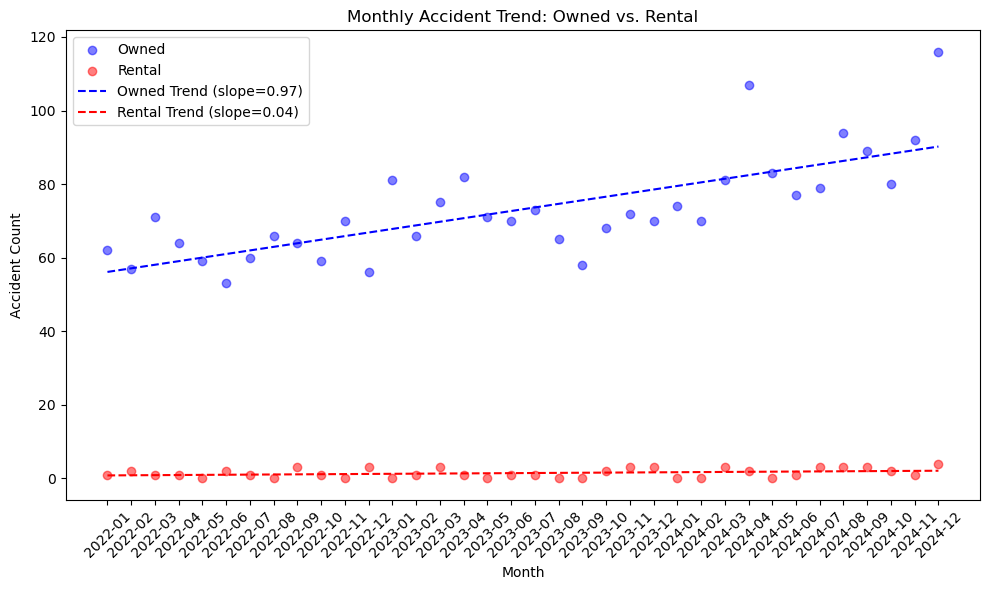

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.scatter(time_summary['MonthStr'],time_summary['OwnedCount'],label='Owned',color='blue',alpha=0.5)
plt.scatter(time_summary['MonthStr'],time_summary['RentalCount'],label='Rental',color='red',alpha=0.5,marker='o')

plt.plot(time_summary['MonthStr'], trend_owned(time_summary['MonthNum']),
         'b--', label=f'Owned Trend (slope={coef_owned[0]:.2f})')
plt.plot(time_summary['MonthStr'], trend_rental(time_summary['MonthNum']),
         'r--', label=f'Rental Trend (slope={coef_rental[0]:.2f})')

plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Accident Count')
plt.title('Monthly Accident Trend: Owned vs. Rental')
plt.legend()
plt.tight_layout()
plt.show()

#### Result

This hypothesis is partly correct with a 0.97 slope of Owned, a 0.04 subtle slope of Rental

### Hypothesis 2

Hypothesis 2: Private‐owned bikes and rental bikes show different peak crash times by hour.

In [23]:
for df in [df_owned,df_rental]:
    df['Hour']=df['CrashDatetime'].dt.hour

In [33]:
def time_period(hour):
    if 0<=hour<6:
        return 'Night(0-6)'
    elif 6<=hour<12:
        return 'Morning(6-12)'
    elif 12<=hour<18:
        return 'Afternoon(12-18)'
    else:
        return 'Evening(18-24)'
for df in [df_owned,df_rental]:
    df['TimePeriod']=df['Hour'].apply(time_period)

TimePeriod
Evening(18-24)      1154
Morning(6-12)        387
Night(0-6            342
Afternoon(12-18)      51
Name: count, dtype: int64 



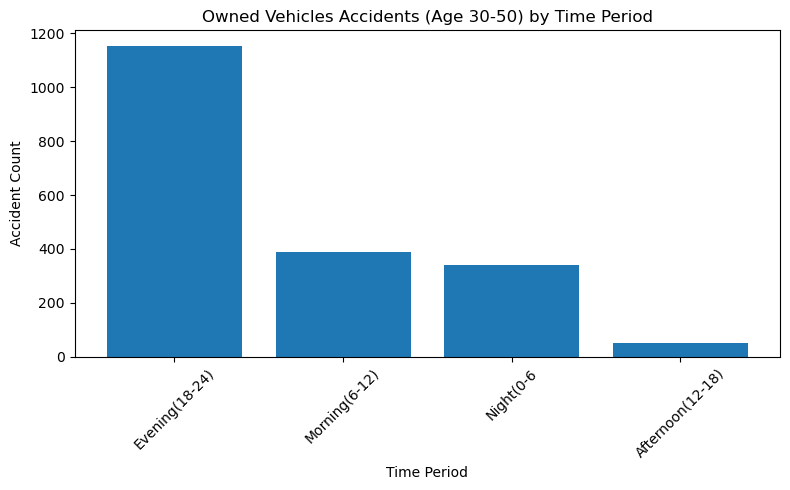

TimePeriod
Evening(18-24)    24
Night(0-6          9
Morning(6-12)      6
Name: count, dtype: int64 



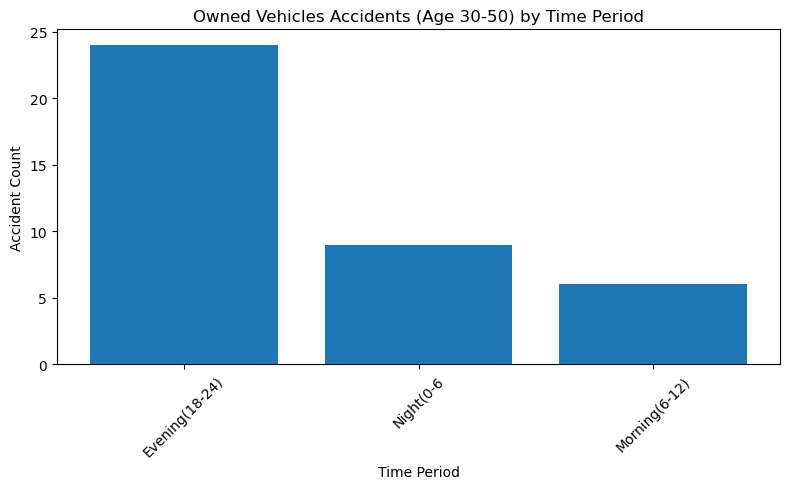

In [38]:
for df in [df_owned,df_rental]:
    mask=df['AGE'].between(30,50,inclusive="both")
    df_30_50=df[mask]
    period_counts=df_30_50['TimePeriod'].value_counts()
    print(period_counts,"\n")

    plt.figure(figsize=(8, 5))
    plt.bar(period_counts.index, period_counts.values)
    plt.xlabel('Time Period')
    plt.ylabel('Accident Count')
    plt.title('Owned Vehicles Accidents (Age 30-50) by Time Period')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### Result

The hypothesis is partly correct.

### Hypothesis 3

Hypothesis 3: Either they are riding rental or owned bikes, younger people (children excluded) are tend to have no injury when an accident happened.

Because the amount of crashes that people involved in aged more than 90 is too low, may exclude them.

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [60]:
AGE_MIN, AGE_MAX = 20, 89
bins   = list(range(AGE_MIN, AGE_MAX + 1, 10))
labels = [f'{i}-{i+9}' for i in bins[:-1]]


=== Owned Vehicle Regression ===
  Slope     = -0.001247
  Intercept = 0.264547
  R²        = 0.8018
  p-value   = 0.0158
  Std. err  = 0.000310


C:\Users\Yiting LI\AppData\Local\Temp\ipykernel_6168\1157424307.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('AgeGroup')['NoInjury']


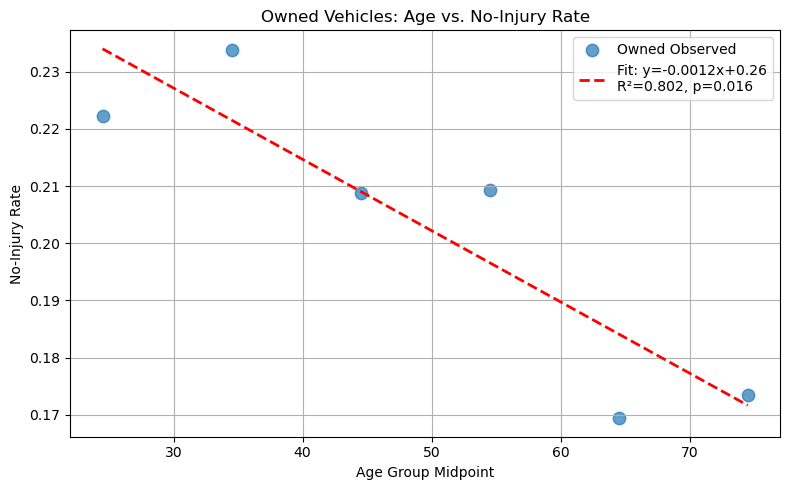


=== Rental Vehicle Regression ===
  Slope     = 0.011605
  Intercept = -0.260407
  R²        = 0.4064
  p-value   = 0.1733
  Std. err  = 0.007012


C:\Users\Yiting LI\AppData\Local\Temp\ipykernel_6168\1157424307.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('AgeGroup')['NoInjury']


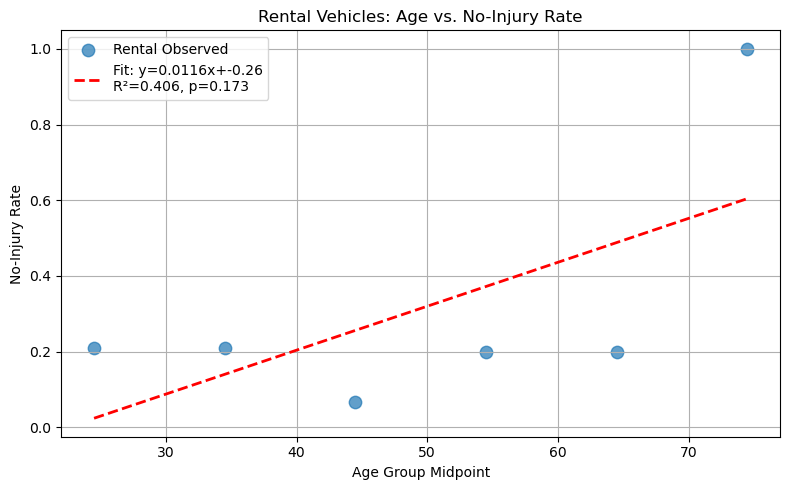

In [63]:
for name, df in [('Owned', df_owned), ('Rental', df_rental)]:
    df_young = df[df['AGE'].between(AGE_MIN, AGE_MAX, inclusive='both')].copy()
    df_young['NoInjury'] = (df_young['CRASH_TYPE'] == 'NO INJURY / DRIVE AWAY').astype(int)

    df_young['AgeGroup'] = pd.cut(
        df_young['AGE'], bins=bins, labels=labels, right=False
    )

    grouped = (
        df_young
        .groupby('AgeGroup')['NoInjury']
        .agg(['mean','count'])
        .reset_index()
        .rename(columns={'mean':'NoInjuryRate','count':'TotalCrashes'})
    )

    grouped['AgeMid'] = grouped['AgeGroup'].apply(
        lambda x: np.mean([int(i) for i in x.split('-')])
    )

    slope, intercept, r_value, p_value, std_err = linregress(
        grouped['AgeMid'],
        grouped['NoInjuryRate']
    )

    print(f"\n=== {name} Vehicle Regression ===")
    print(f"  Slope     = {slope:.6f}")
    print(f"  Intercept = {intercept:.6f}")
    print(f"  R²        = {r_value**2:.4f}")
    print(f"  p-value   = {p_value:.4f}")
    print(f"  Std. err  = {std_err:.6f}")

    # 7. 可视化散点与回归线
    plt.figure(figsize=(8, 5))
    plt.scatter(
        grouped['AgeMid'],
        grouped['NoInjuryRate'],
        s=80,
        alpha=0.7,
        label=f'{name} Observed'
    )
    x_vals = np.array([grouped['AgeMid'].min(), grouped['AgeMid'].max()])
    y_vals = intercept + slope * x_vals
    plt.plot(
        x_vals, y_vals, 'r--', linewidth=2,
        label=f'Fit: y={slope:.4f}x+{intercept:.2f}\n'
              f'R²={r_value**2:.3f}, p={p_value:.3f}'
    )
    plt.xlabel('Age Group Midpoint')
    plt.ylabel('No-Injury Rate')
    plt.title(f'{name} Vehicles: Age vs. No-Injury Rate')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Result

The hypothesis is wrong. When riding their own bike, younger people (children excluded) are tend to have no injury when an accident happened.Yet when I was trying to analyze the rental part, it failed, the p was too low.